## Web scraping and analysis
In this project, we collect some data about the reviews and use pandas to perform a sentiment analysis on them. We then create some word clouds to get an understanding of the good and bad reviews

In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    response = requests.get(url)

    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
print(f"{len(reviews)} total reviews")

1000 total reviews


In [20]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | Very good flight following an ...
1,Not Verified | An hour's delay due to late ar...
2,✅ Trip Verified | I booked through BA becaus...
3,✅ Trip Verified | British airways lost bags ...
4,✅ Trip Verified | The check in process and rew...


Now, we want to tidy up and prepare the texts for the sentiment analysis.

In [21]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

#get rid of verified
rev = df["reviews"]
rev = rev.str.split("|").str.get(1)
df["reviews"] = rev

#function to clean the reviews
def clean_text(text):
    #tokenize text
    text = str(text)
    clear = lambda x: ''.join(char for char in x if char.isalpha() or char.isspace())

    tokens = word_tokenize(clear(text).lower())

    nonsense = ["ba", "nt", "u", "s", "a", "bas"]

    #remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words("english")]
    filtered_tokens = [token for token in filtered_tokens if token not in nonsense]

    #lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    #join tokens back to a string
    processed_text = " ".join(lemmatized_tokens)

    return processed_text

df["clean text"] = df["reviews"].apply(clean_text)
df.head()




,reviews,clean text
0,Very good flight following an equally good f...,good flight following equally good flight rome...
1,An hour's delay due to late arrival of the i...,hour delay due late arrival incoming aircraft ...
2,I booked through BA because Loganair don’t ...,booked loganair dont representative manchester...
3,British airways lost bags in LHR then found...,british airway lost bag lhr found sent cologne...
4,The check in process and reward/loyalty progr...,check process rewardloyalty program mess never...


Sentiment analysis

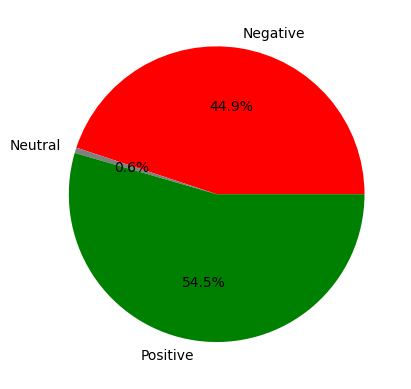

In [22]:
def get_sentiment(text):
    scores = SentimentIntensityAnalyzer().polarity_scores(text)
    scores["compound"] = 0
    if scores["pos"] < scores["neg"]:
        return -1
    elif scores["pos"] > scores["neg"]:
        return 1
    else:
        return 0
    
df["sentiment"] = df["clean text"].apply(get_sentiment)

neutral = df.loc[df["sentiment"]==0].count()["reviews"]
positive = df.loc[df["sentiment"]==1].count()["reviews"]
negative = df.loc[df["sentiment"]==-1].count()["reviews"]

fig, ax = plt.subplots()

sentiments = ["Negative", "Neutral", "Positive"]
counts = [negative, neutral, positive]

bars = ax.pie(counts, colors = ["red", "grey", "green"], labels=["Negative", "Neutral", "Positive"], autopct="%1.1f%%")
plt.show()

Now, separate the positive and negative reviews and perform two separate word clouds to get an understanding of what are the words that get more positive and negative mentions.

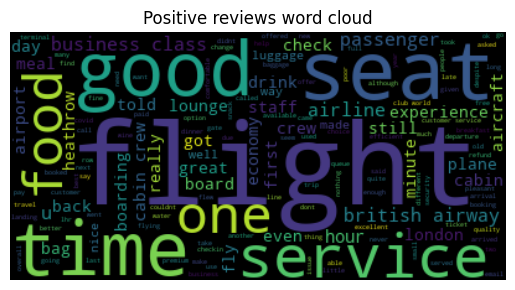

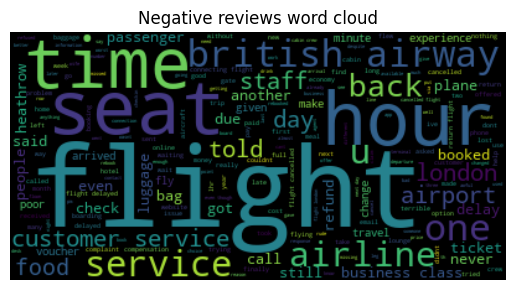

In [23]:
negative_sentiment = df.loc[df["sentiment"]==-1]
positive_sentiment = df.loc[df["sentiment"]==1]

from wordcloud import WordCloud

positive_cloud = positive_sentiment["clean text"].tolist()
wordcloud_pos = WordCloud().generate(str(positive_cloud))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.title("Positive reviews word cloud")
plt.axis("off")
plt.show()

negative_cloud = negative_sentiment["clean text"].tolist()
wordcloud_neg = WordCloud().generate(str(negative_cloud))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.title("Negative reviews word cloud")
plt.axis("off")
plt.show()